# Project 3 -  NLP and Reddit Classification - Part 2: Modeling

### Contents:
#### Part 1:
- API Data Import
- Exploratory Data Analysis

#### Part 2:
- [Model Setup](#Model-Setup)
- [Initial Model Configurations](#Initial-Model-Configurations)
- [Modeling Using Stemmed X Values](#Modeling-Using-Stemmed-X-Values)
- [Change Train/Test Split to 80:20 from 66:33](#Change-Train/Test-Split-to-80:20-from-66:33)
- [Engineer Additional Feature](#Engineer-Additional-Feature)
- [Score Against Train and Test Datasets](#Score-Against-Train-and-Test-Datasets)
- [Confusion Matrix](#Confusion-Matrix)
- [Sensitivity and Specificity](#Sensitivity-and-Specificity)
- [Reddit Post Content Analysis](#Reddit-Post-Content-Analysis)
- [Conclusion](#Conclusion)

## Package Import

In [80]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import confusion_matrix, roc_auc_score

## Model Setup

### Add Column for Stemmed 'selftext'

In [2]:
p_stemmer = PorterStemmer()

In [3]:
data = pd.read_csv('posts_clean.csv')

In [4]:
for i in range(len(data['selftext'])):
    if type(data.loc[i,'selftext']) == float: ###code inserted to identify rows that are float that need to be actioned on
        print (i)
    tokens = (data.loc[i,'selftext']).split()
    stem_tokens = [p_stemmer.stem(j) for j in tokens]
    data.loc[i,'selftext_stem'] = " ".join(stem_tokens)

In [5]:
data.loc[0,'selftext']

'like that scene of taken of liam neeson jumping the fence taking several cuts or the long shot in being considered a selling point i don t understand why either is considered good or bad'

In [6]:
data

,subreddit,selftext,title,selftext_stem
0,0,like that scene of taken of liam neeson jumpin...,in cinematography why are cuts considered bad,like that scene of taken of liam neeson jump t...
1,0,i need an advice since i was grade student i w...,this decision will completely change my life,i need an advic sinc i wa grade student i want...
2,0,every source i found says clinical depression ...,what gave some people the idea that clinical d...,everi sourc i found say clinic depress is caus...
3,0,my little brother got an xbox one and i got a ...,what exactly is the logic behind birthday pres...,my littl brother got an xbox one and i got a t...
4,0,do most people go through a phase in their lif...,do most people go through a phase in their lif...,do most peopl go through a phase in their life...
...,...,...,...,...
3249,1,like in the uk you re allowed to go outside to...,do people judge you for walking round the park,like in the uk you re allow to go outsid to ex...
3250,1,i know that our body s become paralyzed to pre...,why don t we sneeze while sleeping,i know that our bodi s becom paralyz to preven...
3251,1,i have a an android my volume is up but no sou...,audio for mobile reddit app,i have a an android my volum is up but no soun...
3252,1,so i read the news line about the u s having a...,trillion bailout,so i read the news line about the u s have a t...


In [7]:
#review last stemmed entry as an example
list(zip(tokens, stem_tokens))

[('my', 'my'),
 ('mom', 'mom'),
 ('seems', 'seem'),
 ('to', 'to'),
 ('be', 'be'),
 ('annoyed', 'annoy'),
 ('when', 'when'),
 ('i', 'i'),
 ('fidget', 'fidget'),
 ('but', 'but'),
 ('i', 'i'),
 ('don', 'don'),
 ('t', 't'),
 ('notice', 'notic'),
 ('until', 'until'),
 ('she', 'she'),
 ('tells', 'tell'),
 ('me', 'me'),
 ('what', 'what'),
 ('should', 'should'),
 ('i', 'i'),
 ('do', 'do'),
 ('and', 'and'),
 ('how', 'how'),
 ('can', 'can'),
 ('i', 'i'),
 ('stop', 'stop'),
 ('it', 'it')]

### Define X and y Variables

In [83]:
X = data['selftext']
X_stem = data['selftext_stem'] #defining for subsequent model iteration with stemmed results for comparison
y = data['subreddit']

### Setup Train/Test Split

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

## Initial Model Configurations

### Baseline Results

In [10]:
y_test.value_counts(normalize=True)

0    0.545624
1    0.454376
Name: subreddit, dtype: float64

### Setup Multiple Pipelines for Different Models

We will setup multiple models to test which one works best. We will use 5 classifiers: Logistic, K-Nearest Neighbors, Multinomial Naive Bayes, Random Forest and Support Vector Machines. These will be tested using both Count Vectorizer and TFIDF Vectorizer to extract features.

Furthermore, we will test multiple conditions such as including stopwords or not, as well as vary the max number of features generated from the vectorizers. We will then revisit to see if these models perform better or worse using stemmed versions of the X tokens.

Finally, we test the best model configurations with the highest cross validation scores and score against the training and final test set.

In [112]:
pipe1 = Pipeline([('cvec', CountVectorizer()),
                  ('lr', LogisticRegression())])
pipe2 = Pipeline([('tvec', TfidfVectorizer()),
                  ('lr', LogisticRegression())])
pipe3 = Pipeline([('cvec', CountVectorizer()),
                  ('knn', KNeighborsClassifier())])
pipe4 = Pipeline([('tvec', TfidfVectorizer()),
                  ('knn', KNeighborsClassifier())])
pipe5 = Pipeline([('cvec', CountVectorizer()),
                  ('nb', MultinomialNB())])
pipe6 = Pipeline([('tvec', TfidfVectorizer()),
                  ('ft', FunctionTransformer(lambda x: x.todense(), accept_sparse=True)),
                  ('nb', MultinomialNB())])
pipe7 = Pipeline([('cvec', CountVectorizer()),
                  ('rf', RandomForestClassifier())])
pipe8 = Pipeline([('tvec', TfidfVectorizer()),
                  ('ft', FunctionTransformer(lambda x: x.todense(), accept_sparse=True)),
                  ('rf', RandomForestClassifier())])
pipe9 = Pipeline([('cvec', CountVectorizer()),
                  ('svc', SVC())])
pipe10 = Pipeline([('tvec', TfidfVectorizer()),
                  ('svc', SVC())])

pipe1_params = {'cvec__max_features' : [50,100,250,500,1000], #earlier iterations chose lower max features as best params
                'cvec__stop_words' : ['english', None],
                'cvec__ngram_range' : [(1, 1),(1, 2),(1, 3)],
                'lr__penalty' : ['l1', 'l2', 'elasticnet']}
pipe2_params = {'tvec__max_features' : [50,100,250,500,1000],
                'tvec__stop_words' : ['english', None],
                'tvec__ngram_range' : [(1, 1),(1, 2),(1, 3)],
                'lr__penalty' : ['l1', 'l2', 'elasticnet']}
pipe3_params = {'cvec__max_features' : [100,250,500,1000],  #earlier iterations chose lower max features as best params
                'cvec__stop_words' : ['english', None],
                'cvec__ngram_range' : [(1, 1),(1, 2),(1, 3)],
                'knn__n_neighbors' : range(5, 105, 10),
                'knn__p' : [1, 2, 3],
                'knn__weights' : ['distance', 'uniform']}
pipe4_params = {'tvec__max_features' : [100,250,500,1000],
                'tvec__stop_words' : ['english', None],
                'tvec__ngram_range' : [(1, 1),(1, 2),(1, 3)],
                'knn__n_neighbors' : range(5, 105, 10),
                'knn__p' : [1, 2, 3],
                'knn__weights' : ['distance', 'uniform']}
pipe5_params = {'cvec__max_features' : [100,500,1000,2000], #earlier iterations chose higher max features as best params
                'cvec__stop_words' : ['english', None],
                'cvec__ngram_range' : [(1, 1),(1, 2),(1, 3)]}
pipe6_params = {'tvec__max_features' : [100,500,1000,2000],
                'tvec__stop_words' : ['english', None],
                'tvec__ngram_range' : [(1, 1),(1, 2),(1, 3)]}
pipe7_params = {'cvec__max_features' : [100,500,1000,2000],
                'cvec__stop_words' : ['english', None],
                'cvec__ngram_range' : [(1, 1),(1, 2),(1, 3)],
                'rf__n_estimators' : [10,50,100],
                'rf__max_depth' : [5, 7, 10],
                'rf__max_features' : [10, 22, 31, 44], #root of vector max features
                'rf__min_samples_split' : [2,3,5,7],
                'rf__min_samples_leaf' : [3,10,15]}
pipe8_params = {'tvec__max_features' : [100,500,1000,2000],
                'tvec__stop_words' : ['english', None],
                'tvec__ngram_range' : [(1, 1),(1, 2),(1, 3)],
                'rf__n_estimators' : [10,50,100],
                'rf__max_features' : [10, 22, 31, 44], #root of vector max features
                'rf__max_depth' : [5, 7, 10],
                'rf__min_samples_split' : [2,3,5,7],
                'rf__min_samples_leaf' : [3,10,15]}
pipe9_params = {'cvec__max_features' : [100,500,1000,2000],
                'cvec__stop_words' : ['english', None],
                'cvec__ngram_range' : [(1, 1),(1, 2),(1, 3)],
                'svc__C' : [1,50,100],
                'svc__probability' : [True]}
pipe10_params = {'tvec__max_features' : [100,500,1000,2000],
                'tvec__stop_words' : ['english', None],
                'tvec__ngram_range' : [(1, 1),(1, 2),(1, 3)],
                'svc__C' : [1,50,100],
                'svc__probability' : [True]}


In [113]:
gs1 = GridSearchCV(pipe1,
                   param_grid = pipe1_params,
                   cv = 5, n_jobs = -1)

gs2 = GridSearchCV(pipe2,
                   param_grid = pipe2_params,
                   cv = 5, n_jobs = -1)

gs3 = GridSearchCV(pipe3,
                   param_grid = pipe3_params,
                   cv = 5, n_jobs = -1)

gs4 = GridSearchCV(pipe4,
                   param_grid = pipe4_params,
                   cv = 5, n_jobs = -1)

gs5 = GridSearchCV(pipe5,
                   param_grid = pipe5_params,
                   cv = 5, n_jobs = -1)

gs6 = GridSearchCV(pipe6,
                   param_grid = pipe6_params,
                   cv = 5, n_jobs = -1)

gs7 = GridSearchCV(pipe7,
                   param_grid = pipe7_params,
                   cv = 5, n_jobs = -1)

gs8 = GridSearchCV(pipe8,
                   param_grid = pipe8_params,
                   cv = 5, n_jobs = -1)

gs9 = GridSearchCV(pipe9,
                   param_grid = pipe9_params,
                   cv = 5, n_jobs = -1)

gs10 = GridSearchCV(pipe10,
                   param_grid = pipe10_params,
                   cv = 5, n_jobs = -1)

In [37]:
def gsfittrain(gsnum):
    gsnum.fit(X_train, y_train)
    gsnum_model = gsnum.best_estimator_
    print (gsnum.best_score_)
    print (gsnum.best_params_)
    return gsnum_model

In [14]:
gs1_model = gsfittrain(gs1)

0.6087155963302753
{'cvec__max_features': 50, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None, 'lr__penalty': 'l2'}


In [15]:
gs2_model = gsfittrain(gs2)

0.6192660550458715
{'lr__penalty': 'l2', 'tvec__max_features': 1000, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': None}


In [16]:
gs3_model = gsfittrain(gs3)


0.5807339449541284
{'cvec__max_features': 100, 'cvec__ngram_range': (1, 3), 'cvec__stop_words': None, 'knn__n_neighbors': 85, 'knn__p': 2, 'knn__weights': 'uniform'}


In [17]:
gs4_model = gsfittrain(gs4)

0.6128440366972477
{'knn__n_neighbors': 75, 'knn__p': 2, 'knn__weights': 'distance', 'tvec__max_features': 500, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None}


In [18]:
gs5_model = gsfittrain(gs5)

0.6307339449541284
{'cvec__max_features': 2000, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': None}


In [19]:
gs6_model = gsfittrain(gs6)

0.631651376146789
{'tvec__max_features': 2000, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': None}


In [20]:
gs7_model = gsfittrain(gs7)

0.6224770642201835
{'cvec__max_features': 500, 'cvec__ngram_range': (1, 3), 'cvec__stop_words': 'english', 'rf__max_depth': 10, 'rf__max_features': 44, 'rf__min_samples_leaf': 10, 'rf__min_samples_split': 5, 'rf__n_estimators': 10}


In [21]:
gs8_model = gsfittrain(gs8)

0.6243119266055046
{'rf__max_depth': 10, 'rf__max_features': 22, 'rf__min_samples_leaf': 10, 'rf__min_samples_split': 3, 'rf__n_estimators': 100, 'tvec__max_features': 500, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None}


In [114]:
gs9_model = gsfittrain(gs9)

0.6197247706422019
{'cvec__max_features': 1000, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english', 'svc__C': 1, 'svc__probability': True}


In [115]:
gs10_model = gsfittrain(gs10)

0.6362385321100917
{'svc__C': 1, 'svc__probability': True, 'tvec__max_features': 2000, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None}


The best scores for each model are generally quite low. We can try to tweak the X input to use only the stemmed versions to see if there is any improvement. Depending on these results, we can attempt a slightly different set of hyperparameters.

## Modeling Using Stemmed X Values

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X_stem,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [23]:
gs1_stem_model = gsfittrain(gs1)

0.6137614678899083
{'cvec__max_features': 50, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None, 'lr__penalty': 'l2'}


In [24]:
gs2_stem_model = gsfittrain(gs2)

0.6311926605504586
{'lr__penalty': 'l2', 'tvec__max_features': 1000, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None}


In [25]:
gs3_stem_model = gsfittrain(gs3)

0.5821100917431192
{'cvec__max_features': 100, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': None, 'knn__n_neighbors': 65, 'knn__p': 2, 'knn__weights': 'uniform'}


In [26]:
gs4_stem_model = gsfittrain(gs4)

0.6114678899082568
{'knn__n_neighbors': 65, 'knn__p': 2, 'knn__weights': 'distance', 'tvec__max_features': 1000, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': 'english'}


In [27]:
gs5_stem_model = gsfittrain(gs5)

0.6279816513761467
{'cvec__max_features': 2000, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': None}


In [28]:
gs6_stem_model = gsfittrain(gs6)

0.6344036697247707
{'tvec__max_features': 2000, 'tvec__ngram_range': (1, 3), 'tvec__stop_words': None}


In [29]:
gs7_stem_model = gsfittrain(gs7)

0.6224770642201836
{'cvec__max_features': 500, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english', 'rf__max_depth': 7, 'rf__max_features': 31, 'rf__min_samples_leaf': 15, 'rf__min_samples_split': 5, 'rf__n_estimators': 10}


In [30]:
gs8_stem_model = gsfittrain(gs8)

0.6298165137614679
{'rf__max_depth': 10, 'rf__max_features': 31, 'rf__min_samples_leaf': 15, 'rf__min_samples_split': 5, 'rf__n_estimators': 100, 'tvec__max_features': 500, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english'}


In [117]:
gs9_stem_model = gsfittrain(gs9)

0.6486238532110091
{'cvec__max_features': 500, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english', 'svc__C': 1, 'svc__probability': True}


In [118]:
gs10_stem_model = gsfittrain(gs10)

0.6646788990825688
{'svc__C': 1, 'svc__probability': True, 'tvec__max_features': 2000, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': 'english'}


Using stemmed values seems to have improved results across the board albeit at very marginal levels.

Further changes of the hyperparameters were conducted but did not yield any different results as the gridsearch selects nearly all the same hyperparameters as before. This could be due to the posts being generally short so that the occurences don't change that much. Consider re-training using a larger train sample to improve score and eliminating count vectorizer models to save modelling time as they are all outperformed by their TF-IDF vectorizer counterparts.

## Change Train/Test Split to 80:20 from 66:33

We will adjust the train sample to be larger to see if we can improve performance.

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X_stem,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

In [33]:
gs2_stem_model_adj = gsfittrain(gs2)

0.6400376494906246
{'lr__penalty': 'l2', 'tvec__max_features': 1000, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': 'english'}


In [35]:
gs4_stem_model_adj = gsfittrain(gs4)

0.627741768787834
{'knn__n_neighbors': 65, 'knn__p': 2, 'knn__weights': 'distance', 'tvec__max_features': 1000, 'tvec__ngram_range': (1, 3), 'tvec__stop_words': 'english'}


In [37]:
gs6_stem_model_adj = gsfittrain(gs6)

0.636959988188395
{'tvec__max_features': 2000, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english'}


In [39]:
gs8_stem_model_adj = gsfittrain(gs8)

0.628899306068212
{'rf__max_depth': 10, 'rf__max_features': 44, 'rf__min_samples_leaf': 15, 'rf__min_samples_split': 7, 'rf__n_estimators': 100, 'tvec__max_features': 500, 'tvec__ngram_range': (1, 3), 'tvec__stop_words': None}


In [120]:
gs10_stem_model_adj = gsfittrain(gs10)

0.6680776613022295
{'svc__C': 50, 'svc__probability': True, 'tvec__max_features': 2000, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None}


The scores are generally still unsatisfactory even with larger a training set. 

There are two possibilities we can consider. Either the datasets are too similar to be separated by tokenized words or the posts themselves do not contain enough information (eg. the posts are too short) so the models are not able to classify them accurately. 

Combining the title and selftext may yield better results in case there isn't enough data with just the selftext or just the title in cases where there is no selftext (eg. results will be either title+selftext or title+title). Failing this, we may conclude that the datasets are not separable using our models.

## Engineer Additional Feature

An additional step when creating the new feature will be to also include stemming the titles prior to combining as earlier models showed improvement upon stemming.

In [46]:
for i in range(len(data['title'])):
    if type(data.loc[i,'title']) == float: ###code inserted to identify rows that are float that need to be actioned on
        print (i)
    tokens = (data.loc[i,'title']).split()
    stem_tokens = [p_stemmer.stem(j) for j in tokens]
    data.loc[i,'title_stem'] = " ".join(stem_tokens)

In [47]:
data['title_selftxt'] = data['title_stem'] + " " + data['selftext_stem']

In [48]:
data

,subreddit,selftext,title,selftext_stem,title_stem,title_selftxt
0,0,like that scene of taken of liam neeson jumpin...,in cinematography why are cuts considered bad,like that scene of taken of liam neeson jump t...,in cinematographi whi are cut consid bad,in cinematographi whi are cut consid bad like ...
1,0,i need an advice since i was grade student i w...,this decision will completely change my life,i need an advic sinc i wa grade student i want...,thi decis will complet chang my life,thi decis will complet chang my life i need an...
2,0,every source i found says clinical depression ...,what gave some people the idea that clinical d...,everi sourc i found say clinic depress is caus...,what gave some peopl the idea that clinic depr...,what gave some peopl the idea that clinic depr...
3,0,my little brother got an xbox one and i got a ...,what exactly is the logic behind birthday pres...,my littl brother got an xbox one and i got a t...,what exactli is the logic behind birthday pres...,what exactli is the logic behind birthday pres...
4,0,do most people go through a phase in their lif...,do most people go through a phase in their lif...,do most peopl go through a phase in their life...,do most peopl go through a phase in their life...,do most peopl go through a phase in their life...
...,...,...,...,...,...,...
3249,1,like in the uk you re allowed to go outside to...,do people judge you for walking round the park,like in the uk you re allow to go outsid to ex...,do peopl judg you for walk round the park,do peopl judg you for walk round the park like...
3250,1,i know that our body s become paralyzed to pre...,why don t we sneeze while sleeping,i know that our bodi s becom paralyz to preven...,whi don t we sneez while sleep,whi don t we sneez while sleep i know that our...
3251,1,i have a an android my volume is up but no sou...,audio for mobile reddit app,i have a an android my volum is up but no soun...,audio for mobil reddit app,audio for mobil reddit app i have a an android...
3252,1,so i read the news line about the u s having a...,trillion bailout,so i read the news line about the u s have a t...,trillion bailout,trillion bailout so i read the news line about...


In [257]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3254 entries, 0 to 3253
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   subreddit      3254 non-null   int64 
 1   selftext       3254 non-null   object
 2   title          3254 non-null   object
 3   selftext_stem  3254 non-null   object
 4   title_stem     3254 non-null   object
 5   title_selftxt  3254 non-null   object
dtypes: int64(1), object(5)
memory usage: 152.7+ KB


## Remodel With New Feature

In [121]:
X_stem = data['title_selftxt'] #using newly created feature

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X_stem,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

In [46]:
gs2_stem_model_adj = gsfittrain(gs2)

0.6515598700723461
{'lr__penalty': 'l2', 'tvec__max_features': 1000, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None}


In [48]:
gs4_stem_model_adj = gsfittrain(gs4)

0.6365768492543924
{'knn__n_neighbors': 75, 'knn__p': 2, 'knn__weights': 'distance', 'tvec__max_features': 1000, 'tvec__ngram_range': (1, 3), 'tvec__stop_words': 'english'}


In [50]:
gs6_stem_model_adj = gsfittrain(gs6)

0.6611560608297652
{'tvec__max_features': 2000, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': 'english'}


In [52]:
gs8_stem_model_adj = gsfittrain(gs8)

0.6419592499630886
{'rf__max_depth': 10, 'rf__max_features': 31, 'rf__min_samples_leaf': 10, 'rf__min_samples_split': 3, 'rf__n_estimators': 50, 'tvec__max_features': 500, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english'}


In [123]:
gs10_stem_model_adj = gsfittrain(gs10)

0.6680776613022295
{'svc__C': 50, 'svc__probability': True, 'tvec__max_features': 2000, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None}


Based on these cross validation scores, the best model was the SVM Classifier. We will create predictions against the test set to create a confusion matrix which will help us visualize the model's performance better.

## Score Against Train and Test Datasets

Before we create the confusion matrix, let's see how all our models performed overall against the training set as well as the test set. For models using count vectorizer, we will use the last model iterated on (the smaller training size and with the original 'selftext' feature).

In [53]:
print(gs1_stem_model.score(X_train, y_train),", ", gs1_stem_model.score(X_test, y_test)) #logistic, cvec

0.7038033038801383 ,  0.6405529953917051


In [54]:
print(gs2_stem_model_adj.score(X_train, y_train),", ", gs2_stem_model_adj.score(X_test, y_test)) #logistic, tvec

0.7767960046100653 ,  0.6866359447004609


In [55]:
print(gs3_stem_model.score(X_train, y_train),", ", gs3_stem_model.score(X_test, y_test)) #knn, cvec

0.9846331156358048 ,  0.565284178187404


In [56]:
print(gs4_stem_model_adj.score(X_train, y_train),", ", gs4_stem_model_adj.score(X_test, y_test)) #knn, tvec

0.9976949673453708 ,  0.6251920122887865


In [57]:
print(gs5_stem_model.score(X_train, y_train),", ", gs5_stem_model.score(X_test, y_test)) #multinomial nb, cvec

0.7890895121014214 ,  0.6774193548387096


In [58]:
print(gs6_stem_model_adj.score(X_train, y_train),", ", gs6_stem_model_adj.score(X_test, y_test)) #multinomial nb, tvec

0.8259700345754898 ,  0.663594470046083


In [59]:
print(gs7_stem_model.score(X_train, y_train),", ", gs7_stem_model.score(X_test, y_test)) #random forest, cvec

0.7349212447176335 ,  0.6328725038402457


In [60]:
print(gs8_stem_model_adj.score(X_train, y_train),", ", gs8_stem_model_adj.score(X_test, y_test)) #random forest, tvec

0.7118709181713407 ,  0.642089093701997


In [97]:
print(gs9_stem_model.score(X_train, y_train),", ", gs9_stem_model.score(X_test, y_test)) #svm, cvec

0.7741067998463311 ,  0.6559139784946236


In [124]:
print(gs10_stem_model_adj.score(X_train, y_train),", ", gs10_stem_model_adj.score(X_test, y_test)) #svm, tvec

1.0 ,  0.6820276497695853


[0.7038033038801383, 0.9846331156358048, 0.7890895121014214, 0.7349212447176335, 0.7741067998463311]
[0.6405529953917051, 0.565284178187404, 0.6774193548387096, 0.6328725038402457, 0.6559139784946236]


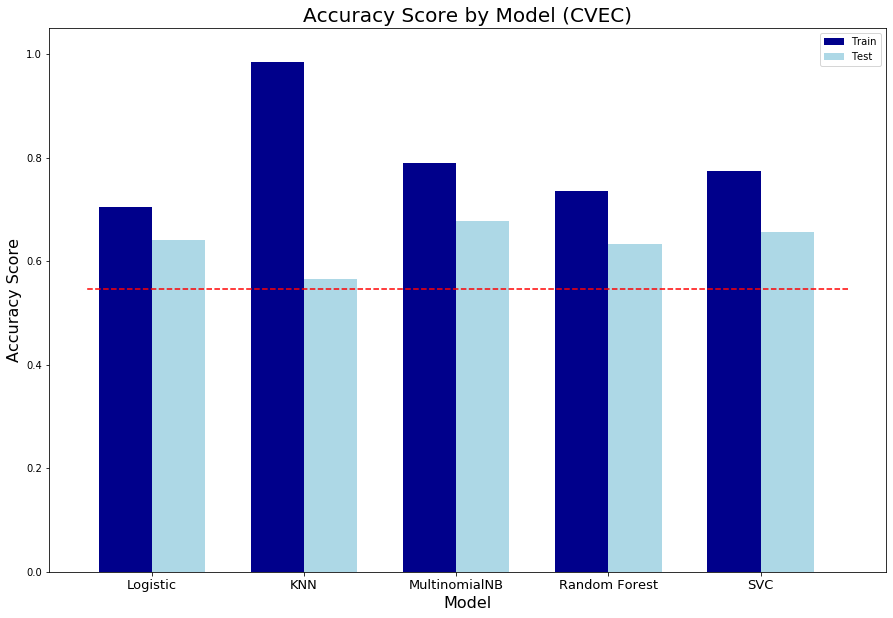

In [241]:
#Model selection graphs
train_scores = [0.7038033038801383, 0.9846331156358048, 0.7890895121014214, 0.7349212447176335, 0.7741067998463311]
test_scores = [0.6405529953917051, 0.565284178187404, 0.6774193548387096, 0.6328725038402457, 0.6559139784946236]
N = 5
ind = np.arange(N)  # the x locations for the groups
width = 0.35

fig, ax = plt.subplots(figsize = (15, 10))

rects1 = ax.bar(ind, train_scores, width, color='darkblue')
rects2 = ax.bar(ind + width, test_scores, width, color='lightblue')
line1 = plt.plot([4.75,-0.25], [0.545624,0.545624], color = "red", linestyle='--', label='baseline')
ax.set_xlabel('Model', fontsize = 16)
ax.set_ylabel('Accuracy Score', fontsize = 16)
ax.set_ylim(0, 1.05)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Logistic', 'KNN', 'MultinomialNB', 'Random Forest', 'SVC'), fontsize = 13)
ax.set_title('Accuracy Score by Model (CVEC)', fontsize = 20)
ax.legend((rects1[0], rects2[0]), ('Train', 'Test'), loc = 'upper right')


print(train_scores)
print(test_scores)

[0.7767960046100653, 0.9976949673453708, 0.8259700345754898, 0.7118709181713407, 1.0]
[0.6866359447004609, 0.6251920122887865, 0.663594470046083, 0.642089093701997, 0.6820276497695853]


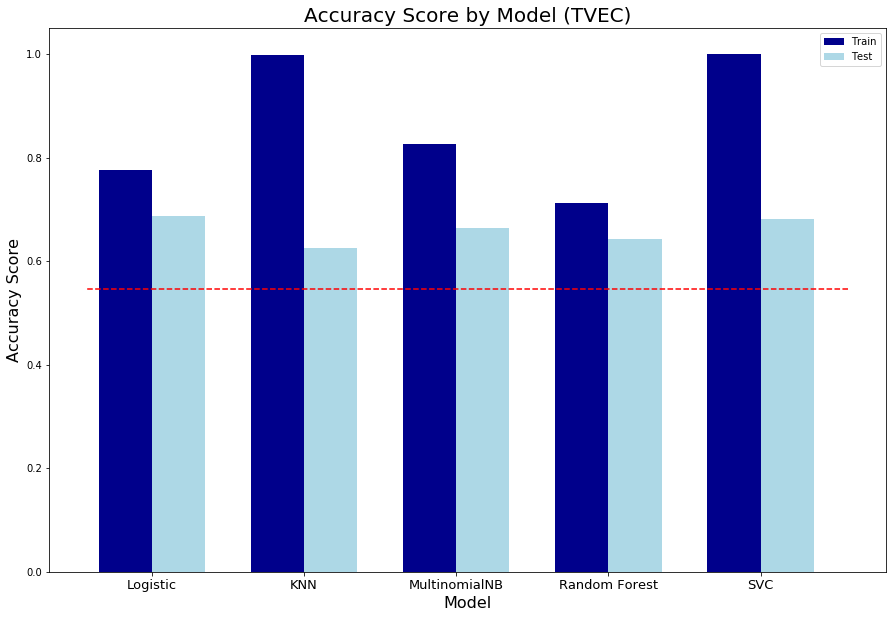

In [242]:
#Model comparison graphs
train_scores = [0.7767960046100653, 0.9976949673453708, 0.8259700345754898, 0.7118709181713407, 1.0]
test_scores = [0.6866359447004609, 0.6251920122887865, 0.663594470046083, 0.642089093701997, 0.6820276497695853]
N = 5
ind = np.arange(N)  # the x locations for the groups
width = 0.35

fig, ax = plt.subplots(figsize = (15, 10))

rects1 = ax.bar(ind, train_scores, width, color='darkblue')
rects2 = ax.bar(ind + width, test_scores, width, color='lightblue')
line1 = plt.plot([4.75,-0.25], [0.545624,0.545624], color = "red", linestyle='--', label='baseline')
ax.set_xlabel('Model', fontsize = 16)
ax.set_ylabel('Accuracy Score', fontsize = 16)
ax.set_ylim(0, 1.05)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Logistic', 'KNN', 'MultinomialNB', 'Random Forest', 'SVC'), fontsize = 13)
ax.set_title('Accuracy Score by Model (TVEC)', fontsize = 20)
ax.legend((rects1[0], rects2[0]), ('Train', 'Test'), loc = 'upper right')


print(train_scores)
print(test_scores)

We can see that our models are generally overfit. The best performing model on the test set was the logistic regression using TF-IDF vectorization at 68.66% followed closely by our selected model, SVC with TF-IDF at 68.2%. The worst performing model was the KNN using count vectorization at 56.5% which is only 2% higher than the red dotted baseline of 54%.

## Confusion Matrix

In [125]:
preds = gs10_stem_model_adj.predict(X_test)

In [126]:
confusion_matrix(y_test, preds)

array([[260,  95],
       [112, 184]])

In [127]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [128]:
print(tn, fp, fn, tp)

260 95 112 184


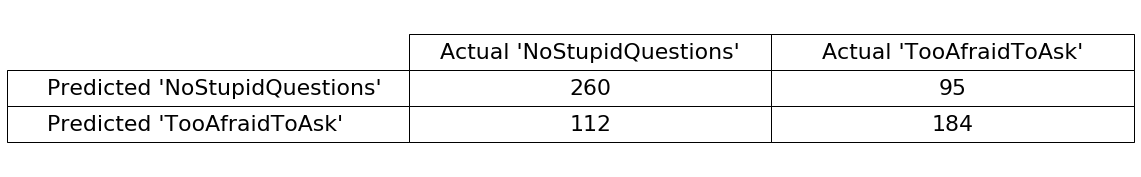

In [256]:
plt.figure(figsize=(13,3))

table = plt.table(cellText=np.array(confusion_matrix(y_test, preds)), rowLabels = ['Predicted \'NoStupidQuestions\'', 'Predicted \'TooAfraidToAsk\''], colLabels = ['Actual \'NoStupidQuestions\'', 'Actual \'TooAfraidToAsk\''], loc='center', cellLoc='center')
table.set_fontsize(22)
table.scale(1,3)
plt.axis('off')
table;

The above matrix shows how the model performed against our test dataset with what subreddit the model predicted vs what the actual subreddit source was. While the overall accuracy score was 68%, the model was much better at classifying posts into 'NoStupidQuestions' than classifying posts into 'TooAfraidToAsk'.

## Sensitivity and Specificity

In [130]:
sens = tp / (tp+fn) #true positive rate
spec = tn / (tn+fp) #true negative rate
print (f'The sensitivity (true positive rate) is {round(sens*100,2)}%. The specificity (true negative rate) is {round(spec*100,2)}%.')

The sensitivity (true positive rate) is 62.16%. The specificity (true negative rate) is 73.24%.


### What does this tell us?

These are the model's ability to predict true positives and true negatives. We can see that the model can predict true posts from 'NoStupidQuestions' at an average rate but is not so good at predicting true posts from 'TooAfraidToAsk'. In the context of our problem, the model is overly sensitive in rejecting questions as being frivolous.

### Receiver Operating Characteristic Curve and Area Under Curve

In [131]:
pred_proba = [i[1] for i in gs10_stem_model_adj.predict_proba(X_test)]

pred_df = pd.DataFrame({'true_values' : y_test,
                      'pred_probs' : pred_proba})

In [139]:
roc_auc_score(pred_df['true_values'], pred_df['pred_probs'])

0.7274457556147697

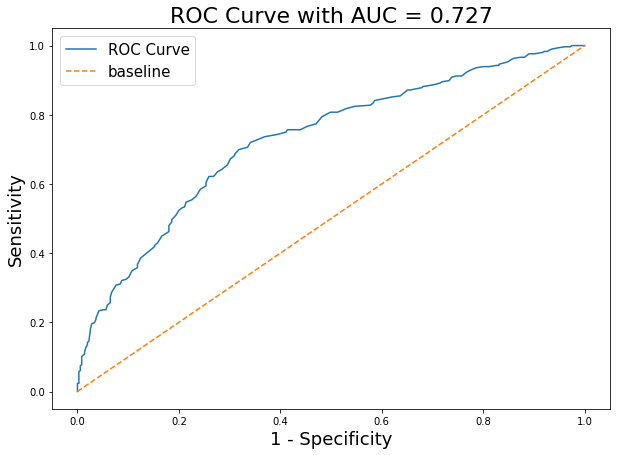

In [246]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=15);

This curve helps visualize the ability of the model to predict true positives as well as the probability of predicting a false positive. The further away the curve is from the dotted line, the better the model is at distinguishing between the two categories. If the curve is at the same level, the model is performing poorly and is no better than guessing.

In this case, the ROC curve is away from the orange line but doesn't come anywhere close to reaching the (0,1) co-ordinate. It is not a great or completely awful model. Additionally, the area under the curve (known as AUC) shows if the positive and negative populations are distinct or overlap in the model. AUC of 1 indicates complete separation where 0.5 is a complete overlap. The AUC in our model is 0.727 which is moderate overlap of the subreddits.

## Reddit Post Content Analysis

In [239]:
wordcount = 0
maxcount = 0
mincount = 1000000000
countlist = []
for i in data['title_selftxt']:
    wordcount += len(i.split(" "))
    if len(i.split(" ")) > maxcount:
        maxcount = len(i.split(" "))
    if len(i.split(" ")) < mincount:
        mincount = len(i.split(" "))
    countlist.append(len(i.split(" ")))
    
print(f"The average title + post word count is {round(wordcount/len(data.index),1)} words.")
print(f"The maximum title + post word count is {maxcount} words.")
print(f"The minimum title + post word count is {mincount} words.")
print(f"The standard deviation of title + post word count is {round(np.std(countlist),1)} words.")


The average title + post word count is 69.3 words.
The maximum title + post word count is 1811 words.
The minimum title + post word count is 3 words.
The standard deviation of title + post word count is 75.4 words.


In [172]:
#reinstantiate tvec for analysis as gridsearchCV did not save the model and vectorizer instantiations
tvec = TfidfVectorizer(max_features=2000, ngram_range=(1,1), stop_words=None) #to match chosen model parameters
tfs = tvec.fit_transform(X_train)
response = tvec.transform(X_test)
feature_array = np.array(tvec.get_feature_names())
tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]

n=20
top_n = feature_array[tfidf_sorting][:n]
print (top_n)

['immedi' 'been' 'famili' 'surgeri' 'mobil' 'oper' 'episod' 'patient'
 'marri' 'wife' 'the' 'seriou' 'date' 'doctor' 'certain' 'anyway' 'either'
 'they' 'sorri' 'hospit']


Based on this data, the top words that appear the most according to the TF-IDF vectorizer have to do with medical conditions and family situations. The posts in general are quite short consisting only of a few sentences. This is reflective of the nature of the subreddits as they are generally just questions that do not have a lot of additional information.

An interesting point to note is that the optimal model included stop words, possibly as a consequence of the fact there was not enough information to separate the posts.

## Conclusion

While the optimal model's predictive accuracy was not very high at 68%, we are able to make a few conclusions and recommendations still.

The model is too sensitive in that it rejects posts to 'NoStupidQuestions' when they are in fact 'TooAfraidToAsk'. Conversely, it does well in classifying posts to 'NoStupidQuestions' because of this. This is also indicative of the dataset not having clear cut verbage/subjects that separate the two subreddits.

However, the main topics that occur most frequently relate to either medical/health conditions and family relationship questions. This indicates that these are the words that influence the model to classify into 'TooAfraidToAsk' the most. If we were to choose an area to invest resources in, it would be towards these two subjects.

Support initiatives could include:
- expansion and promotion of TeleHealth (perhaps an online version)
- relationship helpline and counselling (like 7cups, theSpark, or ginger.io)
- creation/support/expansion of family health conversations (as per study from Nursing Research & Practice journal)<sup>1</sup>
- directly adding to curriculum coping methods and tactics for discussion of sensitive matters

<sup>1</sup>https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3995177/